In [1]:
import numpy as np
# 訓練データと検証データの分割
from sklearn.model_selection import train_test_split
# 予測結果の精度確認（ROC曲線の描画）
from sklearn.metrics import roc_auc_score, roc_curve
# データを扱う
import pandas as pd
# グラフ描画
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
# 特徴量選択
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# 多項式・交互作用特徴量
from sklearn.preprocessing import PolynomialFeatures
import math

In [2]:
import torch
# 自動微分の関数 
from torch.autograd import Variable
# ニューラルネットワークの関数
import torch.nn as nn
# 活性化関数
import torch.nn.functional as F
# 最適化のアルゴリズムの関数
import torch.optim as optim
#ユーティリティのデータから
from torch.utils.data import DataLoader ,TensorDataset, Dataset

In [3]:
class MedcTrainDataset(Dataset):
    def __init__(self):
        super().__init__()
        
        # CSVファイル読み込み（訓練データ）
        df = pd.read_csv('train.csv')
        
        df_x = df.drop(['disease'], axis=1)
        self.df_y = df.loc[:,['disease']]
        
        self.x_desc = df_x.describe()
        self.x_cate , self.x_cont = self.MedcDataChange(df_x)

        self.std_scale = 0
        self.max_scale = 0
        self.dobule_scale = 0
        self.polynomialFlg = 0
        self.binSplitFlg = 0
        self.DataConv()
        
        self.num = len(self.X_train)

    def __getitem__(self, index):
        return self.X_train[index], self.Y_train[index]
    
    def __len__(self):
        return self.num
    
    def MedcDataChange(self, df_x):
        categ_cols = ['Age','Gender']
        contin_cols = ['T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb','AG_ratio']

        ####################################
        ##  データ分割
        ##  説明変数と目的変数に分ける。
        ##  説明変数はカテゴリデータと連続データに分ける。
        ####################################
        x_cate = df_x[categ_cols].copy()
        x_cont = df_x[contin_cols].copy()

        ####################################
        ##  カテゴリデータ
        ##  値変換
        ####################################

        # --------------------------------------
        # Ageの変換の変換
        # '0'  ～18歳未満
        # '1'  18歳～25歳未満
        # '2'  25歳～30歳未満
        # '3'  30歳～35歳未満
        # '4'  35歳～40歳未満
        # '5'  40歳～50歳未満
        # '6'  50歳～60歳未満
        # '7'  60歳～70歳未満
        # '8'  70歳～80歳未満
        # '9'  80歳～
        bins = [0, 18, 25, 30, 35, 40, 50, 60, 70, 80 ,1000]
        #X_cut = pd.cut(x_cate['Age'], bins=bins, labels=['Age' + str(x) for x in range(len(bins)-1)])
        X_cut = pd.cut(x_cate['Age'], bins=bins, labels=False)
        cutTemp = np.zeros((len(X_cut), len(bins) -1 ), dtype=int)
        cutTemp[np.arange(len(X_cut)), X_cut.T] = 1
        df_cut=pd.DataFrame(cutTemp ,columns=['Age' + str(x) for x in range(cutTemp.shape[1])])
        # 列の削除
        x_cate.drop(columns=['Age'], inplace=True, axis=1)
        # 列の追加
        x_cate = pd.concat([x_cate, df_cut], axis=1)

        # --------------------------------------
        # 性別を変換する
        colval=['Female','Male']
        # 初期値０の列を作成する
        for col in colval:
            x_cate[col]=0

        # カテゴリ毎に値編集
        for col in colval:
            x_cate.loc[x_cate['Gender']==col, col]=1
        x_cate.drop(columns=['Gender'],inplace=True)

        return x_cate , x_cont

    
    def NpToPy(self):
        
        #x_temp = pd.concat([self.x_cate , self.x_cont] , axis=1)
        x_temp = self.x_cont.copy()
        x_temp = np.array(x_temp)
        y_temp = np.array(self.df_y)
        
        # 訓練データと検証データに分割
        x_train,x_test,y_train,y_test=train_test_split(x_temp, y_temp, test_size=0.2, random_state=1) 
        
        # numpy の値を torch の値に変換する
        self.X_train = torch.from_numpy(x_train).float()
        self.Y_train = torch.from_numpy(y_train).float()
        self.X_test = torch.from_numpy(x_test).float()
        self.Y_test = torch.from_numpy(y_test).float()
        
        self.in_size  = self.X_train.shape[1]
        self.out_size = self.Y_train.shape[1]
        
    def StdScale(self):
        
        if (self.std_scale == 0):
            bai = 3
            
            col='T_Bil'
            std=self.x_desc.loc['75%',col]*bai
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std
            
            col='D_Bil'
            std=self.x_desc.loc['75%',col]*bai
            std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='ALP'
            #std=self.x_desc.loc['75%',col]*bai
            #std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            std=250
            self.x_cont.loc[self.x_cont[col]>std , col]=std
            std=190
            self.x_cont.loc[self.x_cont[col]<std , col]=std
            
            col='ALT_GPT'
            #std=self.x_desc.loc['75%',col]*bai
            #std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            std=60
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='AST_GOT'
            #std=self.x_desc.loc['75%',col]*bai
            #std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            std=140
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='Alb'
            #std=self.x_desc.loc['75%',col]*bai
            #std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            std=4.5
            self.x_cont.loc[self.x_cont[col]>std , col]=std

            col='AG_ratio'
            #std=self.x_desc.loc['75%',col]*bai
            #std=self.x_cont.loc[self.x_cont[col]<(std),col].max()
            std=1.7
            self.x_cont.loc[self.x_cont[col]>std , col]=std


            col='TP'
            std=5.5
            self.x_cont.loc[self.x_cont[col]<std , col]=std

            self.std_scale = 1
            self.NpToPy()
        
    def MaxScale(self):
        
        if (self.max_scale == 0):
            col='T_Bil'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='D_Bil'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='ALP'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='ALT_GPT'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='AST_GOT'
            if self.std_scale == 1:
                maxval=self.x_desc.loc['std',col]*3
            else:
                maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval

            col='TP'
            maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval
            self.x_cont.loc[:,col]=1-self.x_cont.loc[:,col]

            col='Alb'
            maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval
            self.x_cont.loc[:,col]=1-self.x_cont.loc[:,col]

            col='AG_ratio'
            maxval=self.x_desc.loc['max',col]
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]/maxval
            self.x_cont.loc[:,col]=1-self.x_cont.loc[:,col]

            self.max_scale = 1
            self.NpToPy()

    def DobuleScale(self):
        
        if (self.dobule_scale == 0):
            col='T_Bil'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='D_Bil'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='ALP'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='ALT_GPT'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='AST_GOT'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]

            col='TP'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]
            
            col='Alb'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]
            
            col='AG_ratio'
            self.x_cont.loc[:,col]=self.x_cont.loc[:,col]*self.x_cont.loc[:,col]
            
            self.dobule_scale = 1
            self.NpToPy()
            
    def PolynomialTrance(self):
        if (self.polynomialFlg == 0):
            col1='T_Bil'
            col2='D_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='T_Bil'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='D_Bil'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='AST_GOT'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='T_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='D_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='ALT_GPT'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='AST_GOT'
            col2='T_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='AST_GOT'
            col2='D_Bil'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='AST_GOT'
            col2='ALP'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='TP'
            col2='Alb'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='TP'
            col2='AG_ratio'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            col1='Alb'
            col2='AG_ratio'
            self.x_cont[col1 + '_' + col2]=self.x_cont[col1] * self.x_cont[col2]

            self.polynomialFlg = 1
            self.NpToPy()
        
    def snsPlot(self):
        
        # seabornで相関係数を描画
        plt.figure(figsize=(15,15))
        df_sns = pd.concat([self.x_cont , self.df_y] , axis=1)
        sns.heatmap(df_sns.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
        plt.show()
           
    def boxPlot(self):
        
        df_sns = pd.concat([self.x_cont , self.df_y] , axis=1)
        
        fig, ax = plt.subplots(3,3,figsize=(20,20))
        sns.boxplot(x="disease",y="T_Bil",data=df_sns,ax=ax[0][0])
        sns.boxplot(x="disease",y="D_Bil",data=df_sns,ax=ax[0][1])
        sns.boxplot(x="disease",y="ALP",data=df_sns,ax=ax[0][2])
        sns.boxplot(x="disease",y="ALT_GPT",data=df_sns,ax=ax[1][0])
        sns.boxplot(x="disease",y="AST_GOT",data=df_sns,ax=ax[1][1])
        sns.boxplot(x="disease",y="TP",data=df_sns,ax=ax[1][2])
        sns.boxplot(x="disease",y="Alb",data=df_sns,ax=ax[2][0])
        sns.boxplot(x="disease",y="AG_ratio",data=df_sns,ax=ax[2][1])
        plt.tight_layout()
    
    def binSplit(self):
        if self.binSplitFlg == 0:
            # T_Bilの変換
            col = 'T_Bil'
            bins = [0,  0.85,  1.5,   100]
            self.x_cont[col] = pd.cut(self.x_cont[col], bins=bins, labels=False)

            # D_Bilの変換
            col = 'D_Bil'
            bins = [0,  0.18, 0.21,  0.3,  100]
            self.x_cont[col] = pd.cut(self.x_cont[col], bins=bins, labels=False)

            # ALPの変換
            col = 'ALP'
            bins = [0,  220, 240,  2500]
            self.x_cont[col] = pd.cut(self.x_cont[col], bins=bins, labels=False)

            # ALT_GPTの変換
            col = 'ALT_GPT'
            bins = [0,  20,   25,   40,  1500]
            self.x_cont[col] = pd.cut(self.x_cont[col], bins=bins, labels=False)

            # AST_GOTの変換
            col = 'AST_GOT'
            bins = [0,  30,   75,   1000]
            self.x_cont[col] = pd.cut(self.x_cont[col], bins=bins, labels=False)

            # TPの変換
            col = 'TP'
            bins = [0,  6.0,  6.8,  7,  7.5,  8,  1000]
            self.x_cont[col] = pd.cut(self.x_cont[col], bins=bins, labels=False)

            # Albの変換
            col = 'Alb'
            bins = [0,  3.3,  3.8,  4.5, 1000]
            self.x_cont[col] = pd.cut(self.x_cont[col], bins=bins, labels=False)

            # AG_ratioの変換
            col = 'AG_ratio'
            bins = [0, 1.0,  1.1, 1.2, 1.3, 1.4, 1000]
            self.x_cont[col] = pd.cut(self.x_cont[col], bins=bins, labels=False)

            self.binSplitFlg = 1
            self.NpToPy()
        
    def DataConv(self):
        self.binSplit()
        #self.StdScale()
        #self.MaxScale()
        #self.PolynomialTrance()
        #self.DobuleScale()
        
        

In [4]:
class MedcTestDataset(MedcTrainDataset):
    def __init__(self, x_desc):
        
        # CSVファイル読み込み（訓練データ）
        df = pd.read_csv('test.csv')

        self.x_desc = x_desc
        self.x_cate , self.x_cont = self.MedcDataChange(df)
        
        self.std_scale = 0
        self.max_scale = 0
        self.dobule_scale = 0
        self.polynomialFlg = 0
        self.binSplitFlg = 0
        self.DataConv()
        
        self.num = len(self.x_cate)

    def __getitem__(self, index):
        return self.X_test[index]
    
    def __len__(self):
        return self.num
    
    def NpToPy(self):
        
        #x_temp = pd.concat([self.x_cate , self.x_cont] , axis=1)
        x_temp = self.x_cont.copy()
        x_temp = np.array(x_temp)
        
        # numpy の値を torch の値に変換する
        self.X_vat = torch.from_numpy(x_temp).float()

    def snsPlot(self):
        
        # seabornで相関係数を描画
        plt.figure(figsize=(15,15))
        df_sns = self.x_cont
        sns.heatmap(df_sns.corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
        plt.show()

## 訓練データの読み込み

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


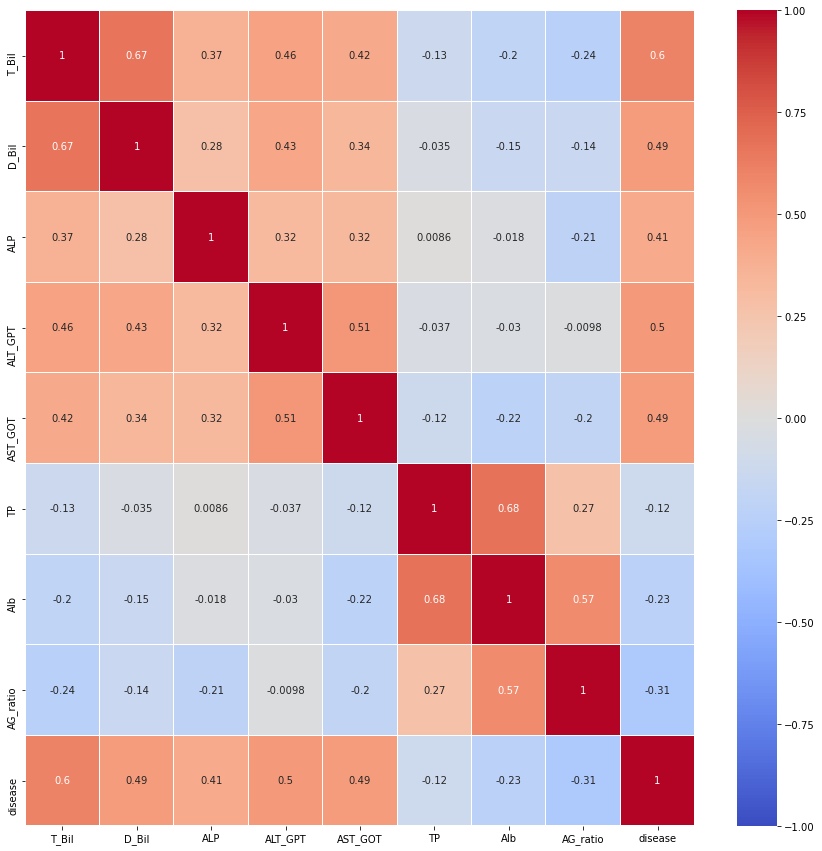

In [5]:
train_dataset = MedcTrainDataset()
total_samples = len(train_dataset)
train_dataset.snsPlot()

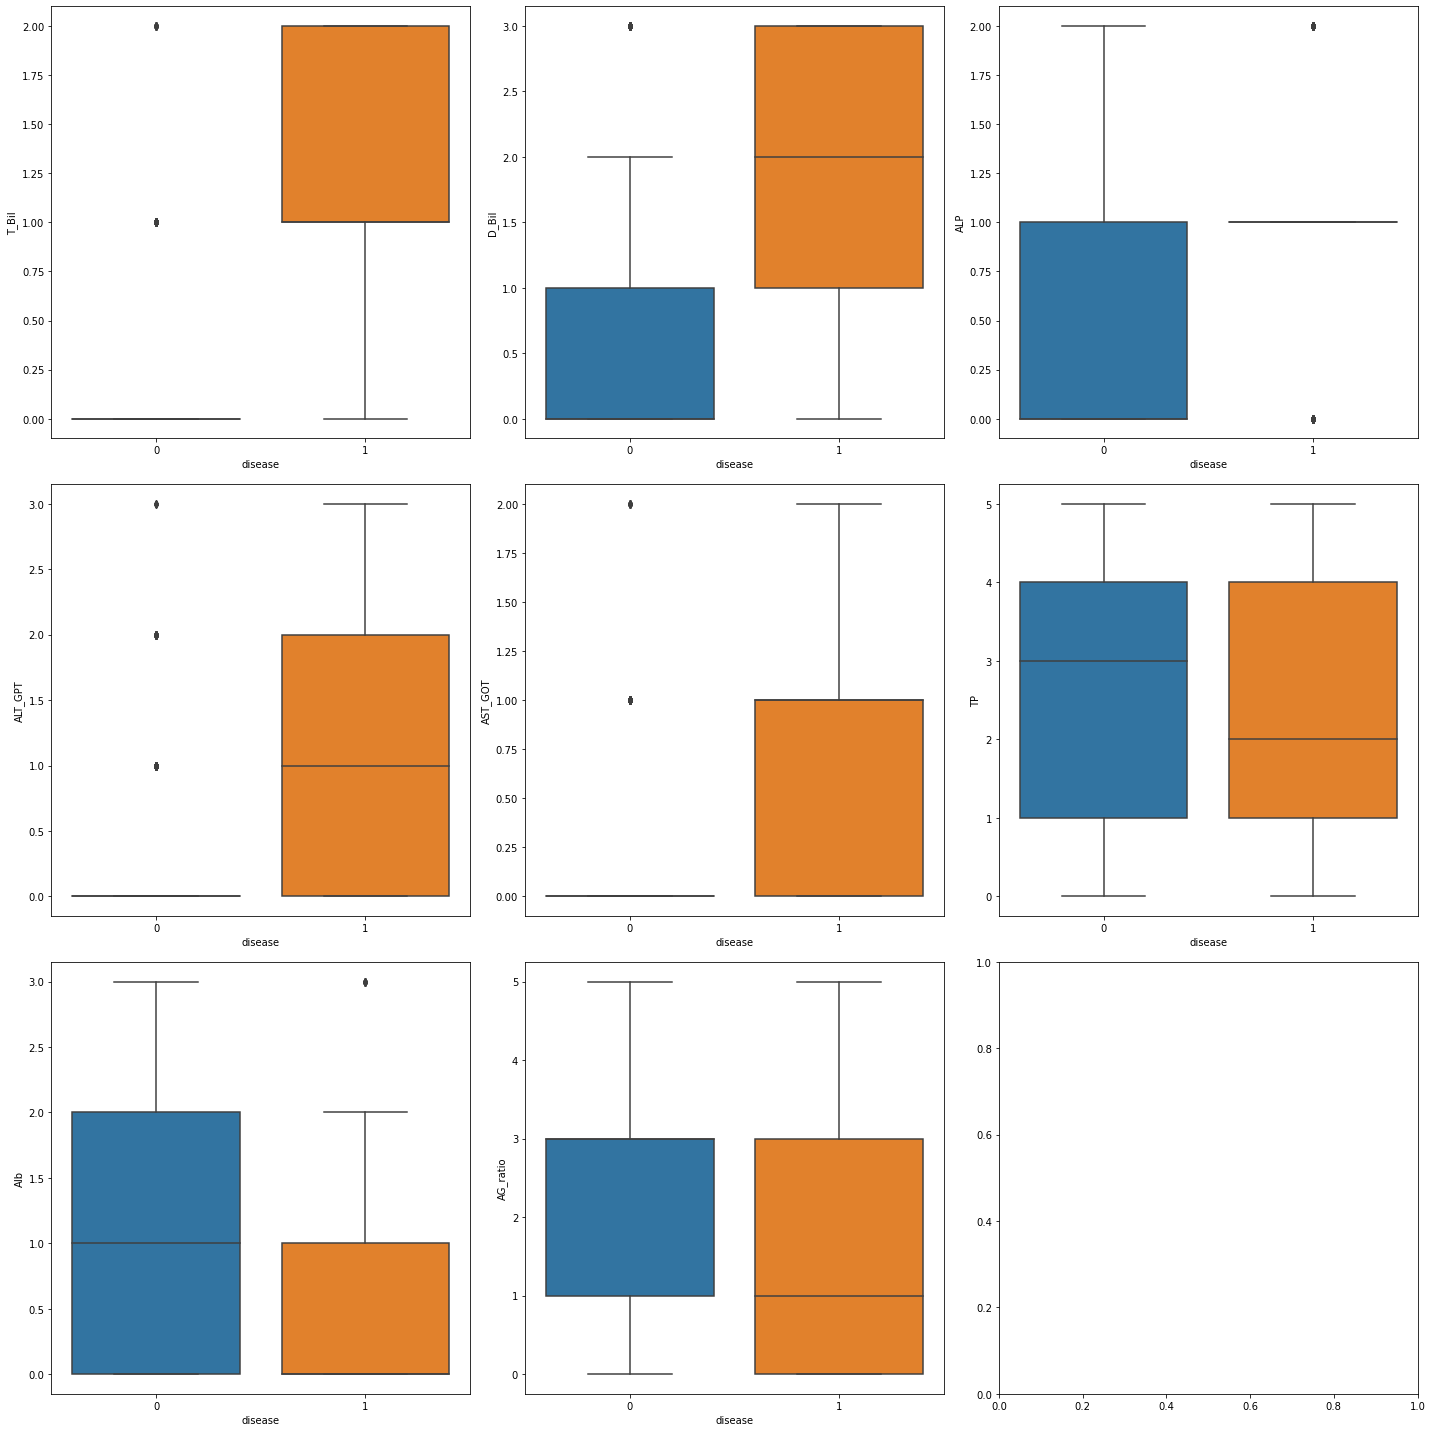

In [6]:
train_dataset.boxPlot()

In [7]:
train_dataset.x_cont.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000
mean,0.676471,1.250588,0.674118,0.669412,0.532941,2.447059,0.851765,1.989412
std,0.815074,1.235338,0.749346,1.016996,0.675656,1.623632,0.810213,1.537480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,3.000000
75%,1.000000,3.000000,1.000000,1.000000,1.000000,4.000000,1.000000,3.000000
max,2.000000,3.000000,2.000000,3.000000,2.000000,5.000000,3.000000,5.000000


## 評価データの読み込み

In [8]:
test_dataset = MedcTestDataset(train_dataset.x_desc)

In [9]:
test_dataset.x_cont.describe()

,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
count,350.000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,0.680,1.197143,0.717143,0.625714,0.482857,2.517143,0.911429,2.074286
std,0.787,1.198611,0.770140,0.995648,0.658637,1.673489,0.892911,1.578934
min,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,3.000000
75%,1.000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,3.000000
max,2.000,3.000000,2.000000,3.000000,2.000000,5.000000,3.000000,5.000000


# 分類

In [10]:
batchsize=100

# batch_size ：学習する時にまとめるデータ数
# shuffle    : データをランダムに並び替える場合はTrue
#train_loader = DataLoader(train ,batch_size=30, shuffle=True, num_workers=2)
train_loader = DataLoader(dataset=train_dataset ,batch_size=batchsize, shuffle=True)

In [11]:
node1=40
node2=10


# Module を継承して、Netクラスを作成する
#  ノード数や階層を増やす　⇒　精度が向上する、学習のパフォーマンスは落ちる
#  ノード数や階層を減らす　⇒　精度が下がる、学習のパフォーマンスは上がる
#   　ノードや階層を変更しても精度が上がらない　⇒　入力データが不足している
class Net1(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net1 ,self).__init__()

        # 全結合層
        self.fc1 = nn.Linear(train_dataset.in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1 , node2)           # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(node2,  train_dataset.out_size)        # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
#        x = torch.relu(self.fc1(x))              # 入力のノードを中間層（１階層目）に渡して結果を得る
#        x = F.sigmoid(self.fc2(x))               # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = torch.sigmoid (self.fc1(x))           # 入力のノードを中間層（１階層目）に渡して結果を得る
        #x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))           # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        #x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))           # 中間層（２階層目）の結果を出力層に渡す
        return x

In [12]:
# モデルの定義
model1 = Net1()
# 損失の定義 (平均二乗誤差)
criterion1 = nn.BCELoss()
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
optimizer1 = optim.Adam(model1.parameters() , lr=0.01)

# 回帰

In [13]:
node1=20
node2=10

# Module を継承して、Netクラスを作成する
class Net2(nn.Module):
    # 初期化の関数
    def __init__(self):
        super(Net2 ,self).__init__()

        # 全結合層
        self.fc1 = nn.Linear(train_dataset.in_size , node1)         # nn.Linear (入力のノード数 , 中間層ノード数)
        self.fc2 = nn.Linear(node1 , node2)                         # nn.Linear (中間層ノード数 , 中間層ノード数)
        self.fc3 = nn.Linear(node2,  2)                             # nn.Linear (中間層ノード数 , 出力のノード数)
    
    # ネットワークを通して、出力値を求める関数
    def forward(self ,x):
        x = torch.sigmoid(self.fc1(x))           # 入力のノードを中間層（１階層目）に渡して結果を得る
        x = torch.sigmoid(self.fc2(x))           # 中間層（１階層目）を中間層（２階層目）に渡して結果を得る
        x = torch.sigmoid(self.fc3(x))           # 中間層（２階層目）の結果を出力層に渡す
        return F.log_softmax(x , dim=0)

In [14]:
# モデルの定義
model2 = Net2()
# 損失の定義 (平均二乗誤差)
criterion2 = nn.MSELoss()
# 最適化のアルゴリズムの選択　（Adam：Stochastic Gradient Descent）
optimizer2 = optim.Adam(model2.parameters() , lr=0.01)

In [15]:
def outhk(y1 ,y2):
    
    tmp = torch.zeros(len(y1)).reshape(-1,1)
    for i in range(len(y1)):
        if((y1[i] == 0) or (y2[i] == 0)):
            tmp[i] = 0
        else:
            tmp[i] = 1
    return tmp      
    

In [16]:
#loss_list1 = []
#loss_list2 = []
#logdisp=1
#accuracy_list1 = []
#accuracy_list2 = []
#accuracy_list3 = []
#
#correct_counter1 = 0
#correct_counter2 = 0
#correct_counter3 = 0
#acccnt=len(train_dataset)*logdisp
#print('rec_cnt', acccnt)
#epochs=50
#
#
## トレーニングの回数分ループする。
#for epoch in range(epochs):
#    # 損失を初期化　
#    total_loss1 = 0
#    total_loss2 = 0
#    
#    for x_train , y_train in train_loader:
#
#        # 出力を計算する 
#        output1 = model1(x_train)
#        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
#        loss1 = criterion1(output1 ,y_train)
#
#        correct_temp = (y_train == output1.round()).sum()
#        correct_counter1 += correct_temp
#
#
#        #  one-hot vector に変換します。
#        Y_ohv = torch.zeros(2 * y_train.shape[0] ,dtype=torch.float32).reshape(y_train.shape[0], 2 )
#        for i in range(y_train.shape[0]):
#            Y_ohv[i, y_train[i].numpy()] = 1.0 # one-hot vector
#        
#        # 出力を計算する 
#        output2 = model2(x_train)
#        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
#        loss2 = criterion2(output2 ,Y_ohv)
#        out_tmp=torch.max(output2 ,axis=1)[1].reshape(-1,1)
#        
#        correct_temp = (y_train == out_tmp).sum()
#        correct_counter2 += correct_temp
#        
#        #correct_temp = ((y_train == torch.max(output2 ,1)[1]) OR (y_train == output1.round())).sum()
#        correct_temp = (y_train == outhk(output1.round() ,out_tmp)).sum()
#        correct_counter3 += correct_temp
#        
#        # パラメータの勾配を初期化する
#        optimizer1.zero_grad()
#        optimizer2.zero_grad()
#        # ロスを伝播する
#        loss1.backward()
#        loss2.backward()
#        # パラメータを更新する
#        optimizer1.step()
#        optimizer2.step()
#
#        # トータルロスを格納
#        total_loss1 += loss1.item()
#        total_loss2 += loss2.item()
#        
#        
#    
#    # 回数とトータルロスを表示する
#    if (epoch+1)%logdisp == 0:
#        loss_tmp1=total_loss1/acccnt
#        loss_tmp2=total_loss2/acccnt
#        print(f'Epoch\t{epoch+1}\tLoss\t{loss_tmp1:.8f}\taccu:\t{(correct_counter1*100)/acccnt:.3f}%')
#        print(f'\t\tLoss\t{loss_tmp2:.8f}\taccu:\t{(correct_counter2*100)/acccnt:.3f}%')
#        print(f'\t\t\t\t\taccu:\t{(correct_counter3*100)/acccnt:.3f}%')
#        print('------------------------------------------------')
#        
#        accuracy_list1.append(correct_counter1.item()*100/(acccnt))
#        accuracy_list2.append(correct_counter2.item()*100/(acccnt))
#        accuracy_list3.append(correct_counter3.item()*100/(acccnt))
#        loss_list1.append(loss_tmp1)
#        loss_list2.append(loss_tmp2)
#        total_loss=0
#        correct_counter1 = 0
#        correct_counter2 = 0
#        correct_counter3 = 0
        

In [17]:
loss_list1 = []
logdisp=1
accuracy_list1 = []

correct_counter1 = 0
acccnt=len(train_dataset)*logdisp
print('rec_cnt', acccnt)
epochs=50


# トレーニングの回数分ループする。
for epoch in range(epochs):
    # 損失を初期化　
    total_loss1 = 0
    
    for x_train , y_train in train_loader:

        # 出力を計算する 
        output1 = model1(x_train)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss1 = criterion1(output1 ,y_train)

        correct_temp = (y_train == output1.round()).sum()
        correct_counter1 += correct_temp

        
        # パラメータの勾配を初期化する
        optimizer1.zero_grad()
        # ロスを伝播する
        loss1.backward()
        # パラメータを更新する
        optimizer1.step()

        # トータルロスを格納
        total_loss1 += loss1.item()
        
        
    
    # 回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp1=total_loss1/acccnt
        print(f'Epoch\t{epoch+1}\tLoss\t{loss_tmp1:.8f}\taccu:\t{correct_counter1*100/acccnt:.3f}%')
        
        accuracy_list1.append(correct_counter1.item()*100/(acccnt))
        loss_list1.append(loss_tmp1)
        total_loss=0
        correct_counter1 = 0
        

rec_cnt 680
Epoch	1	Loss	0.00691704	accu:	56.000%
Epoch	2	Loss	0.00643266	accu:	66.000%
Epoch	3	Loss	0.00560861	accu:	80.000%
Epoch	4	Loss	0.00484558	accu:	83.000%
Epoch	5	Loss	0.00439417	accu:	82.000%
Epoch	6	Loss	0.00416463	accu:	83.000%
Epoch	7	Loss	0.00409315	accu:	83.000%
Epoch	8	Loss	0.00415805	accu:	83.000%
Epoch	9	Loss	0.00403838	accu:	84.000%
Epoch	10	Loss	0.00398935	accu:	84.000%
Epoch	11	Loss	0.00398495	accu:	84.000%
Epoch	12	Loss	0.00399997	accu:	84.000%
Epoch	13	Loss	0.00396520	accu:	84.000%
Epoch	14	Loss	0.00397526	accu:	84.000%
Epoch	15	Loss	0.00390913	accu:	85.000%
Epoch	16	Loss	0.00389844	accu:	84.000%
Epoch	17	Loss	0.00386045	accu:	84.000%


..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Epoch	18	Loss	0.00389693	accu:	84.000%
Epoch	19	Loss	0.00388050	accu:	85.000%
Epoch	20	Loss	0.00389384	accu:	85.000%
Epoch	21	Loss	0.00382044	accu:	85.000%
Epoch	22	Loss	0.00381757	accu:	85.000%
Epoch	23	Loss	0.00380517	accu:	85.000%
Epoch	24	Loss	0.00381445	accu:	85.000%
Epoch	25	Loss	0.00382514	accu:	85.000%
Epoch	26	Loss	0.00371925	accu:	85.000%
Epoch	27	Loss	0.00372505	accu:	85.000%
Epoch	28	Loss	0.00376385	accu:	84.000%
Epoch	29	Loss	0.00369208	accu:	85.000%
Epoch	30	Loss	0.00366884	accu:	86.000%
Epoch	31	Loss	0.00365825	accu:	85.000%
Epoch	32	Loss	0.00362502	accu:	85.000%
Epoch	33	Loss	0.00361622	accu:	86.000%
Epoch	34	Loss	0.00360139	accu:	85.000%
Epoch	35	Loss	0.00360814	accu:	86.000%
Epoch	36	Loss	0.00359201	accu:	85.000%
Epoch	37	Loss	0.00362977	accu:	86.000%
Epoch	38	Loss	0.00357377	accu:	85.000%
Epoch	39	Loss	0.00357877	accu:	86.000%
Epoch	40	Loss	0.00357440	accu:	85.000%
Epoch	41	Loss	0.00351165	accu:	86.000%
Epoch	42	Loss	0.00349148	accu:	86.000%
Epoch	43	Loss	0.00349011	

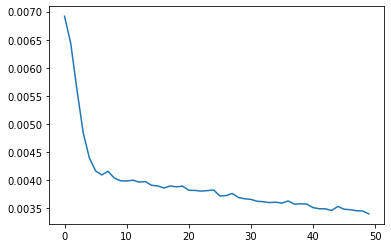

In [18]:
# ロスのプロット
plt.plot(loss_list1)

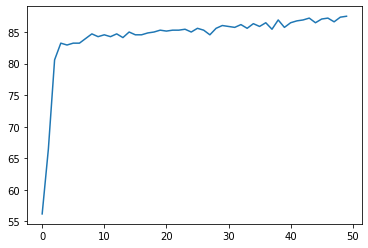

In [19]:
plt.plot(accuracy_list1)

In [20]:
loss_list2 = []
logdisp=10
accuracy_list2 = []

correct_counter2 = 0
acccnt=len(train_dataset)*logdisp
print('rec_cnt', acccnt)
epochs=150


# トレーニングの回数分ループする。
for epoch in range(epochs):
    # 損失を初期化　
    total_loss2 = 0
    
    for x_train , y_train in train_loader:

        #  one-hot vector に変換します。
        Y_ohv = torch.zeros(2 * y_train.shape[0] ,dtype=torch.float32).reshape(y_train.shape[0], 2 )
        for i in range(y_train.shape[0]):
            Y_ohv[i, y_train[i].numpy()] = 1.0 # one-hot vector
        
        # 出力を計算する 
        output2 = model2(x_train)
        # 損失の計算 (出力の結果；output と 正解：y_trainを渡す)
        loss2 = criterion2(output2 ,Y_ohv)
        out_tmp=torch.max(output2 ,axis=1)[1].reshape(-1,1)
        
        correct_temp = (y_train == out_tmp).sum()
        correct_counter2 += correct_temp
        
        
        # パラメータの勾配を初期化する
        optimizer2.zero_grad()
        # ロスを伝播する
        loss2.backward()
        # パラメータを更新する
        optimizer2.step()

       # トータルロスを格納
        total_loss1 += loss1.item()
        total_loss2 += loss2.item()
        
        
    
    # 回数とトータルロスを表示する
    if (epoch+1)%logdisp == 0:
        loss_tmp2=total_loss2/acccnt
        print(f'Epoch\t{epoch+1}\tLoss\t{loss_tmp2:.8f}\taccu:\t{correct_counter2*100/acccnt:.3f}%')
        
        accuracy_list2.append(correct_counter2.item()*100/(acccnt))
        loss_list2.append(loss_tmp2)
        total_loss=0
        correct_counter2 = 0
        

rec_cnt 6800
Epoch	10	Loss	0.02673775	accu:	80.000%
Epoch	20	Loss	0.02673648	accu:	84.000%
Epoch	30	Loss	0.02673564	accu:	86.000%
Epoch	40	Loss	0.02673485	accu:	86.000%
Epoch	50	Loss	0.02673443	accu:	87.000%
Epoch	60	Loss	0.02673412	accu:	87.000%
Epoch	70	Loss	0.02673325	accu:	88.000%
Epoch	80	Loss	0.02673288	accu:	88.000%
Epoch	90	Loss	0.02673260	accu:	88.000%
Epoch	100	Loss	0.02673265	accu:	88.000%
Epoch	110	Loss	0.02673247	accu:	88.000%
Epoch	120	Loss	0.02673145	accu:	89.000%
Epoch	130	Loss	0.02673119	accu:	89.000%
Epoch	140	Loss	0.02673092	accu:	89.000%
Epoch	150	Loss	0.02673094	accu:	90.000%


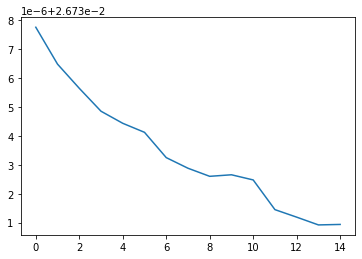

In [21]:
# ロスのプロット
plt.plot(loss_list2)

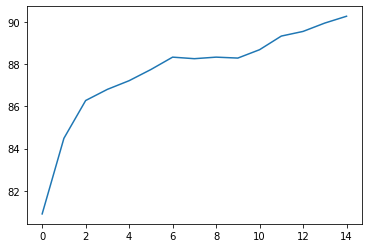

In [22]:
plt.plot(accuracy_list2)

In [23]:
#plt.plot(accuracy_list3)

## 誤差の確認

In [24]:
#print(Y_test)

In [25]:
# 学習を行わないモードに変更
model1.eval()
model2.eval()

y_hat1=model1(train_dataset.X_test).data
y_hat1=y_hat1.round().numpy()

y_hat2=model2(train_dataset.X_test).data
y_hat2=torch.max(y_hat2 ,1)[1].reshape(-1,1)

y_hat=outhk(y_hat1 , y_hat2).numpy()
y_hat=y_hat.reshape(-1,1)

y_true=train_dataset.Y_test.numpy()


accuracy = np.sum(y_true == y_hat) /len(y_true)
print(accuracy)


0.8588235294117647


## ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）

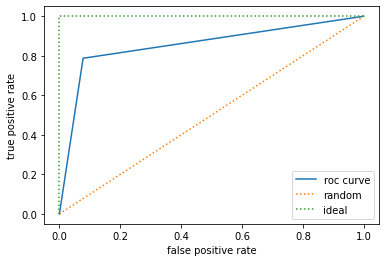

[2. 1. 0.]


In [26]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_hat)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [27]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_true, y_score=y_hat)
print("AUC:", auc_score)

AUC: 0.8548611111111112


#  予測する

In [28]:
y_predict1=model1(test_dataset.X_vat).data
y_predict1=y_predict1.round().numpy()

y_predict2=model2(test_dataset.X_vat).data
y_predict2=torch.max(y_predict2 ,1)[1].reshape(-1,1)

y_predict=outhk(y_predict1 , y_predict2).numpy()
y_predict=y_predict.reshape(-1,1)


print(y_predict)
y_predict = y_predict.round()
df_out = pd.DataFrame(np.array(y_predict ,dtype=np.int32), columns=['val'])

df_out.to_csv('./submit.csv', encoding='utf_8_sig' , header=False)


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.

# モデルの保存

In [45]:
#model_path = 'model1.pth'
#torch.save(model1.to('cpu').state_dict(), model_path)
#model_path = 'model2.pth'
#torch.save(model2.to('cpu').state_dict(), model_path)

In [128]:
# 学習を行わないモードに変更
model1.eval()
model2.eval()

y_hat=model2(train_dataset.X_test).data
y_hat=torch.max(y_hat ,1)[1].reshape(-1,1).numpy()


y_true=train_dataset.Y_test.numpy()


accuracy = np.sum(y_true == y_hat) /len(y_true)
print(accuracy)

0.8470588235294118


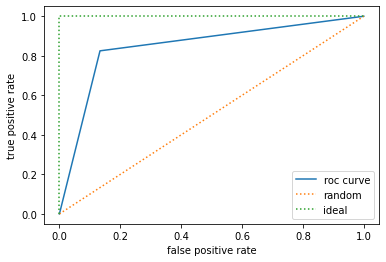

[2 1 0]


In [129]:
# ROC曲線の描画（偽陽性率、真陽性率、閾値の算出）
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_hat)
plt.plot(fpr, tpr, label='roc curve')
plt.plot([0, 1], [0, 1], linestyle=':', label='random')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', label='ideal')
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()
print(thresholds)

In [130]:
# AUCスコアの算出
auc_score = roc_auc_score(y_true=y_true, y_score=y_hat)
print("AUC:", auc_score)

AUC: 0.8458333333333334
